# Loading dependencies + data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import figs

import sys
sys.path.append('..')
import lb

%load_ext autoreload
%autoreload 2


In [2]:
figs.set_mpl_style()


In [3]:
Dall = lb.exp.Data.load('0.4')
D = Dall.qualified()


Large difference 83ms between duration 26914ms and end-start difference 26831ms for pid=md5:8c43bec3733bb9976c197bff02dbf4e2 trial=3
Large difference 155ms between duration 6858ms and end-start difference 6703ms for pid=md5:fce1be10fd7e4f749e9b5f731056d7f3 trial=4
Modal row count 34. # matching 193 / 235
# with no programming 171 / 235
# valid workers 171 / 235


# Enumerating programs

In [4]:
if 'dc' in locals():
    del dc
    import gc
    gc.collect()

dc = lb.fitting.default_program_enumeration(D)


Loading from cached file took 40.36 seconds. Last modified 2024-07-01T02:15:22.118727+00:00 (36 days, 13:39:23.153394 ago)


In [5]:
dc.show()


--------------------
('cgcMaps', 14) 39650 elapsed {'enum:trace': '0.117s', 'enum:program': '0.918s', 'enum:program_count_matrix': '1.529s'}
Behavior #participants=166 trace range=12-40 perc(50=14.00, 75=15.75, 95=18.75, 99=22.70)
TraceSet #1124 #programs=39650 trace range 12-20 iters=10400 non-monotonic=0
trace (full) missing total=4/166 (2.41%) unique=4/31 (12.90%) avg count per unique=4/4=1.00 {'BBADDBECADDCDBBDCDBECA', 'BDCAEBDCAEBBECCCECCECA', 'EBDCDBCAEBDCAEBECCBECECA', 'DCCEBBAECBACEECEBBECECCCEBCCEBBECCEBBECA'}
trace (by 2+) missing total=0/150 (0.00%) unique=0/15 (0.00%)  set()
program (full) missing total=15/166 (9.04%) unique=15/69 (21.74%) avg count per unique=15/15=1.00
program (by 2+) missing total=0/121 (0.00%) unique=0/24 (0.00%) 
Participant % with trace within max length 97.59% (assuming astar with include_equal_score)

--------------------
('cgcMaps', 3) 6742493 elapsed {'enum:trace': '2.048s', 'enum:program': '196.208s', 'enum:program_count_matrix': '393.378s'}
Beha

# Plot cross-MDP BICs

In [6]:
# First, fit models
fit_models = lb.fitting.analysis(dc)


Loading from cached file took 0.08 seconds. Last modified 2024-07-01T12:19:55.389620+00:00 (36 days, 3:35:33.872930 ago)
score_reuse_and_reward FitResult(range=[12825.23, 14569.54], success=51/51, reach_minima=49/51, best_params=Args(b=2.5249118142314417, prior_beta=0.3785865069958296, p_normal=0.9067700021498019, step_count_coef=0.5160047821587829), match_best_params=47/51, elapsed_sec_range=[1005.68, 3814.91])
score_reuse FitResult(range=[13482.30, 14161.19], success=51/51, reach_minima=45/51, best_params=Args(b=4.229798418431225, prior_beta=0.48215058508394065, p_normal=0.876270926517888), match_best_params=40/51, elapsed_sec_range=[331.65, 1827.14])
score_mdl_and_reward FitResult(range=[15267.23, 15267.23], success=51/51, reach_minima=51/51, best_params=Args(mdl_beta=0.5252790119387051, step_count_coef=0.8516355052577316), match_best_params=51/51, elapsed_sec_range=[14.43, 35.23])
score_mdl FitResult(range=[16787.27, 16787.27], success=51/51, reach_minima=51/51, best_params=Args(md

In [7]:
def plot_model_comparison(fit_models, *, tag=None):
    dd = pd.DataFrame([
        {
            'Model': m.name,
            'BIC': fit_models[m.score_key].bic,
            'step-cost': 'reward' in m.score_key,
            'color': m.color,
        }
        for m in figs.models.all
    ])

    f, ax = plt.subplots()
    width = 0.25

    ticks = []
    for group_idx, (_, rows) in enumerate(dd.groupby('step-cost')):
        for idx, row in enumerate(rows.itertuples()):
            pos = group_idx + idx * width
            r = ax.barh(pos, row.BIC, width, color=row.color)
            ax.bar_label(r, padding=-40, color='black', fmt='%.0f')
            ticks.append((pos, row.Model.replace('grammar induction +', 'grammar induction\n+')))

    ax.set_yticks(*zip(*ticks))
    plt.xlabel('BIC')
    plt.ylim(*plt.ylim()[::-1])

    if tag is None:
        tag = ''
    else:
        tag = f'-{tag}'
    figs.save(f'model-programs-across{tag}.pdf')

def plot_model_comparison(fit_models, *, tag=None):
    dd = pd.DataFrame([
        {
            'Model': m.name,
            'BIC': fit_models[m.score_key].bic,
            'step-cost': 'reward' in m.score_key,
            'color': m.color,
        }
        for m in figs.models.all
    ])

    f, ax = plt.subplots()
    width = 0.25

    ticks = []
    for group_idx, (_, rows) in enumerate(dd.groupby('step-cost')):
        for idx, row in enumerate(rows.itertuples()):
            pos = group_idx + idx * width
            ax.bar(pos, row.BIC, width, color=row.color, label=figs.wrap_model_name(row.Model))
            ticks.append((pos, figs.wrap_model_name(row.Model)))

    ax.set_xticks(*zip(*ticks), rotation=45, ha='right')
    plt.ylabel('BIC')

    if tag is None:
        tag = ''
    else:
        tag = f'-{tag}'
    figs.set_ax_size(3, 2.5, ax)
    figs.save(f'model-programs-across{tag}.pdf')

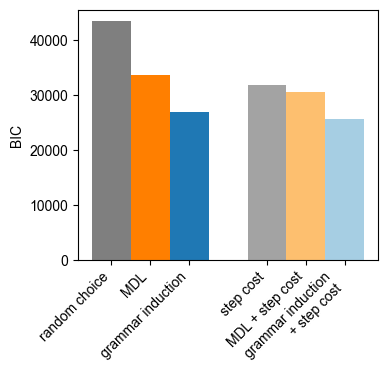

In [8]:
plot_model_comparison(fit_models)

# Model comparison table

In [9]:
def lrt_latex(fit_models, hyp, null, dof_difference, *, show=False):
    hyp_m = fit_models[hyp.score_key]
    null_m = fit_models[null.score_key]
    p = hyp_m.likelihood_ratio_test(null_m)

    # # For logging param differences. For debugging
    # hyp_params = set(hyp.result['final_args'].free_parameters)
    # null_params = set(null.result['final_args'].free_parameters)
    # print(hyp_params - null_params)

    # We're repeating this here as validation
    from scipy.stats.distributions import chi2
    assert hyp_m.dof - null_m.dof == dof_difference, (hyp_m.dof, null_m.dof, dof_difference)
    LR = 2 * (hyp_m.log_likelihood - null_m.log_likelihood)
    p2 = chi2.sf(LR, dof_difference)
    assert np.isclose(p, p2)

    # Return a tuple for now
    rv = f'$\chi^2({dof_difference})={LR:.1f}$', f'${figs.pvalue(p)}$'
    if show:
        print(', '.join((hyp.name, null.name) + rv))
    return rv

def print_comparisons(fit_models):
    lrt_latex(fit_models, figs.models.reward, figs.models.null, 1, show=True)
    lrt_latex(fit_models, figs.models.mdl, figs.models.null, 1, show=True)
    lrt_latex(fit_models, figs.models.reuse, figs.models.null, 3, show=True)
    print()
    lrt_latex(fit_models, figs.models.mdl_and_reward, figs.models.reward, 1, show=True)
    lrt_latex(fit_models, figs.models.reuse_and_reward, figs.models.reward, 3, show=True)
    print()
    lrt_latex(fit_models, figs.models.mdl_and_reward, figs.models.mdl, 1, show=True)
    lrt_latex(fit_models, figs.models.reuse_and_reward, figs.models.reuse, 1, show=True)


In [10]:
print_comparisons(fit_models)

step cost, random choice, $\chi^2(1)=11658.3$, $p < .001$
MDL, random choice, $\chi^2(1)=9844.8$, $p < .001$
grammar induction, random choice, $\chi^2(3)=16454.7$, $p < .001$

MDL + step cost, step cost, $\chi^2(1)=1226.6$, $p < .001$
grammar induction + step cost, step cost, $\chi^2(3)=6110.6$, $p < .001$

MDL + step cost, MDL, $\chi^2(1)=3040.1$, $p < .001$
grammar induction + step cost, grammar induction, $\chi^2(1)=1314.1$, $p < .001$


In [11]:
def table_lrt(fit_models):
    df = pd.DataFrame([
        {
            ('', 'Model'): ('' if m.name == 'MDL' else r'\midrule')+figs.makecell(figs.wrap_model_name(m.name)),
            **{
                ('Nested model', f'{m2.name}'): (
                # f'{m2.name}': (
                    figs.makecell(lrt_latex(fit_models, m, m2, dof_difference=fit_models[m.score_key].dof-fit_models[m2.score_key].dof))
                    if fit_models[m.score_key].free_parameters > fit_models[m2.score_key].free_parameters else '')
                for m2 in [figs.models.null, figs.models.reward, figs.models.mdl, figs.models.reuse]
            },
        }
        for m in figs.models.all
        if m.key != 'null' # skip random b/c it has no comparisons
    ])
    df[('Nested model', figs.makecell(['MDL or', 'grammar induction']))] = [m+g for m, g in zip(df[('Nested model', 'MDL')], df[('Nested model', 'grammar induction')])]
    del df[('Nested model', 'MDL')]
    del df[('Nested model', 'grammar induction')]
    df.columns = pd.MultiIndex.from_tuples(df.columns)
    display(df)
    print(figs.pd_to_latex(df))


In [12]:
table_lrt(fit_models)

\
                                               Model   
0                                     \makecell{MDL}   
1               \midrule\makecell{grammar induction}   
2                       \midrule\makecell{step cost}   
3                 \midrule\makecell{MDL + step cost}   
4  \midrule\makecell{grammar induction \\ + step ...   

                                   Nested model  \
                                  random choice   
0   \makecell{$\chi^2(1)=9844.8$ \\ $p < .001$}   
1  \makecell{$\chi^2(3)=16454.7$ \\ $p < .001$}   
2  \makecell{$\chi^2(1)=11658.3$ \\ $p < .001$}   
3  \makecell{$\chi^2(2)=12884.9$ \\ $p < .001$}   
4  \makecell{$\chi^2(4)=17768.9$ \\ $p < .001$}   

                                                \
                                     step cost   
0                                                
1                                                
2                                                
3  \makecell{$\chi^2(1)=1226.6$ \\ $p < .001$}   
4  \makecell{$\chi^2(3)=6110.6$ \\ $p < .001$}   

                                                
        \makecell{MDL or \\ grammar induction}  
0                                               
1                                               
2                                               
3  \makecell{$\chi^2(1)=3040.1$ \\ $p < .001$}  
4  \makecell{$\chi^2(1)=1314.1$ \\ $p < .001$}

\begin{tabular}{llll}
\toprule
                                                    & \multicolumn{3}{l}{Nested model} \\
                                              Model &                                random choice &                                   step cost &      \makecell{MDL or \\ grammar induction} \\
\midrule
                                     \makecell{MDL} &  \makecell{$\chi^2(1)=9844.8$ \\ $p < .001$} &                                             &                                             \\
               \midrule\makecell{grammar induction} & \makecell{$\chi^2(3)=16454.7$ \\ $p < .001$} &                                             &                                             \\
                       \midrule\makecell{step cost} & \makecell{$\chi^2(1)=11658.3$ \\ $p < .001$} &                                             &                                             \\
                 \midrule\makecell{MDL + step cost} & \makecell{$\chi^2(2)=12884.9$ \\ $p < .0

# Plot single-MDP BICs

In [13]:
def per_task_bic(dc, fit_models, m):
    print()
    print('Computing per-task BIC for', m.score_key)

    fit = fit_models[m.score_key]
    a = fit.result['final_args']

    def original_fn(res, a):
        return res.crossent(a, batch_score=m.batch_score_fn)

    if 'grammar induction' in m.name:
        print('Because this includes the reuse model, integrating nuisance parameters out.')
        # HACK These nuisance_params are copy/pasted from model fitting.
        nuisance_params = dict(p_end=np.linspace(0.1, 0.9, 9))
        fn = lambda res, outer_a: lb.fitting.integrate_nuisance_for_negative_log_fn(lambda a: original_fn(res, a), outer_a, nuisance_params)
    else:
        nuisance_params = None
        fn = original_fn

    lls = np.array([
        -fn(res, a)
        for res in dc.d
    ])
    # They will differ only in the case of nuisance parameter integration.
    print(f'Log probability of data, summed across tasks: {np.sum(lls):.2f}. Log probability of entire dataset: {fit.log_likelihood:.2f}.')
    if nuisance_params is None:
        assert np.isclose(np.sum(lls), fit.log_likelihood), (np.sum(lls), fit.log_likelihood)

    obs_counts = np.array([
        sum(res.bs.program_counts.values())
        for res in dc.d
    ])
    assert np.sum(obs_counts) == fit.observation_count, (np.sum(obs_counts), fit.observation_count)

    bics = fit.dof * np.log(obs_counts) - 2 * lls

    return pd.DataFrame(dict(bic=bics, ll=lls, obs_count=obs_counts), index=[res.mdp_name for res in dc.d])

def per_task_bic_for_all_models(dc, fit_models):
    return {
        m.score_key: per_task_bic(dc, fit_models, m)
        for m in figs.models.all
    }

In [14]:
# Load above analysis
fit_models = lb.fitting.analysis(dc)

model_bics = per_task_bic_for_all_models(dc, fit_models)

Loading from cached file took 0.01 seconds. Last modified 2024-07-01T12:19:55.389620+00:00 (36 days, 3:35:34.461443 ago)
score_reuse_and_reward FitResult(range=[12825.23, 14569.54], success=51/51, reach_minima=49/51, best_params=Args(b=2.5249118142314417, prior_beta=0.3785865069958296, p_normal=0.9067700021498019, step_count_coef=0.5160047821587829), match_best_params=47/51, elapsed_sec_range=[1005.68, 3814.91])
score_reuse FitResult(range=[13482.30, 14161.19], success=51/51, reach_minima=45/51, best_params=Args(b=4.229798418431225, prior_beta=0.48215058508394065, p_normal=0.876270926517888), match_best_params=40/51, elapsed_sec_range=[331.65, 1827.14])
score_mdl_and_reward FitResult(range=[15267.23, 15267.23], success=51/51, reach_minima=51/51, best_params=Args(mdl_beta=0.5252790119387051, step_count_coef=0.8516355052577316), match_best_params=51/51, elapsed_sec_range=[14.43, 35.23])
score_mdl FitResult(range=[16787.27, 16787.27], success=51/51, reach_minima=51/51, best_params=Args(md

In [15]:
def plot_model_comparison_between_task(dc, model_bics, *, tag=None):
    df = pd.DataFrame([
        {
            'Model': m.name_label,
            'mdp_name': mdp_name,
            'MDP': label,
            'BIC': model_bics[m.score_key].bic[mdp_name],
            'Log_Likelihood': model_bics[m.score_key].ll[mdp_name],
            'step-cost': 'reward' in m.key,
        }
        for m in figs.models.all
        for label, mdp_name in figs.mdp_labels_and_names
    ])

    _, ax = plt.subplots()
    sns.barplot(
        x='MDP', y='BIC', hue='Model',
        data=df,
        palette=[m.color for m in figs.models.all])
    plt.xlabel('Task')
    plt.gca().get_legend().remove()

    if tag is None:
        tag = ''
    else:
        tag = f'-{tag}'
    figs.set_ax_size(5, 2.5, ax)
    figs.save(f'model-programs-between{tag}.pdf')

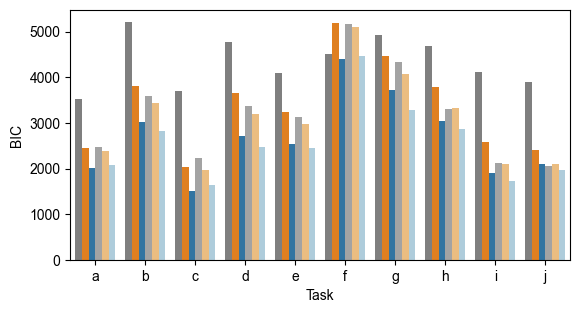

In [16]:
plot_model_comparison_between_task(dc, model_bics)

# Parameter/BIC/LL table

In [17]:
def parameter_table(fit_models):
    param_label = dict(
        step_count_coef=r'\beta_{\text{StepCost}}',
        prior_beta=r'\beta_{\text{GrammarInduction}}',
        mdl_beta=r'\beta_{\text{MDL}}',
        b=r'\alpha',
        p_end=r'p_{end}',
        p_normal=r'p_{call}',
    )

    rows = []

    for model in figs.models.all:
        name = model.score_key
        fit = fit_models[name]
        fit_args = fit.result['final_args']

        args = list(fit_args.free_parameters.keys())
        assert len(args) == fit.dof
        arg_strs = []
        for a in args:
            fi = lb.fitting.Args.field_info[a]
            assert a in fit_args.free_parameters
            value = getattr(fit_args, a)
            if a == 'p_normal':
                assert fit_args.free_parameters[a] == 1/2
                assert fi.bounds == lb.fitting.BoundTypes.prob
                value = 1 - value # HACK We need to subtract from 1 b/c we call this a p(call) in the text
            else:
                assert fit_args.free_parameters[a] == 1, 'Ensuring all started at same'
                assert fi.bounds in (lb.fitting.BoundTypes.pos, lb.fitting.BoundTypes.pos_w0)
                if fi.bounds == lb.fitting.BoundTypes.pos_w0:
                    print(f'WARNING: Argument {a} has bounds that permit 0 as a value, make sure to note if relevant')
            arg_strs.append(f'${param_label[a]}={value:.2f}$')
        rule = '' if model.key == 'null' else r'\midrule '
        rows.append({
            'Model': rule+figs.makecell(figs.wrap_model_name(model.name)),
            figs.makecell('Log likelihood'.split()): '{:.1f}'.format(fit.log_likelihood),
            'BIC': '{:.1f}'.format(fit.bic),
            figs.makecell('Param. count'.split()): fit.dof,
            'Parameters': figs.makecell(arg_strs, align='l'),
        })
    rows = pd.DataFrame(rows)
    print(figs.pd_to_latex(rows.set_index(['Model']), kwargs=dict(index=True)))

In [18]:
parameter_table(fit_models)

\begin{tabular}{lllrl}
\toprule
{} & \makecell{Log \\ likelihood} &      BIC &  \makecell{Param. \\ count} &                                                                                                                  Parameters \\
\midrule
\makecell{random choice}                             &                     -21709.7 &  43419.4 &                           0 &                                                                                                              \makecell[l]{} \\
\midrule \makecell{MDL}                              &                     -16787.3 &  33582.0 &                           1 &                                                                                     \makecell[l]{$\beta_{\text{MDL}}=0.98$} \\
\midrule \makecell{grammar induction}                &                     -13482.3 &  26986.9 &                           3 &                                    \makecell[l]{$\alpha=4.23$ \\ $\beta_{\text{GrammarInduction}}=0.48$ \\ $p_{call}=0.1

# Confound 1: Remove preprocessing

In [19]:
if 'dc' in locals():
    del dc
    import gc
    gc.collect()

dc = lb.fitting.Analyses.confound_no_canon(D)

Loading from cached file took 41.46 seconds. Last modified 2024-07-01T00:00:37.774198+00:00 (36 days, 15:55:14.467313 ago)


In [20]:
fit_models = lb.fitting.analysis(dc)

Loading from cached file took 0.08 seconds. Last modified 2024-07-02T12:00:30.216536+00:00 (35 days, 3:56:03.871792 ago)
score_reuse_and_reward FitResult(range=[14905.06, 16665.01], success=51/51, reach_minima=21/51, best_params=Args(b=45.481763697044386, prior_beta=0.26429333548447287, p_normal=0.8300083353008979, step_count_coef=0.5874839773443553), match_best_params=2/51, elapsed_sec_range=[813.29, 5854.00])
score_reuse FitResult(range=[15706.61, 15888.84], success=51/51, reach_minima=5/51, best_params=Args(b=68.123435503456, prior_beta=0.3805029240717043, p_normal=0.7188193187246924), match_best_params=1/51, elapsed_sec_range=[652.88, 2514.47])
score_mdl_and_reward FitResult(range=[16514.30, 16514.30], success=51/51, reach_minima=51/51, best_params=Args(mdl_beta=0.26138742576618806, step_count_coef=0.9640407594309199), match_best_params=51/51, elapsed_sec_range=[15.40, 34.06])
score_mdl FitResult(range=[18430.93, 18430.93], success=51/51, reach_minima=51/51, best_params=Args(mdl_be

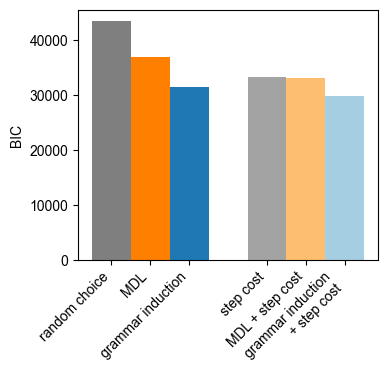

step cost, random choice, $\chi^2(1)=10090.8$, $p < .001$
MDL, random choice, $\chi^2(1)=6558.9$, $p < .001$
grammar induction, random choice, $\chi^2(3)=12007.5$, $p < .001$

MDL + step cost, step cost, $\chi^2(1)=301.4$, $p < .001$
grammar induction + step cost, step cost, $\chi^2(3)=3519.8$, $p < .001$

MDL + step cost, MDL, $\chi^2(1)=3833.3$, $p < .001$
grammar induction + step cost, grammar induction, $\chi^2(1)=1603.1$, $p < .001$
\begin{tabular}{lllrl}
\toprule
{} & \makecell{Log \\ likelihood} &      BIC &  \makecell{Param. \\ count} &                                                                                                                   Parameters \\
\midrule
\makecell{random choice}                             &                     -21710.4 &  43420.7 &                           0 &                                                                                                               \makecell[l]{} \\
\midrule \makecell{MDL}                              &   

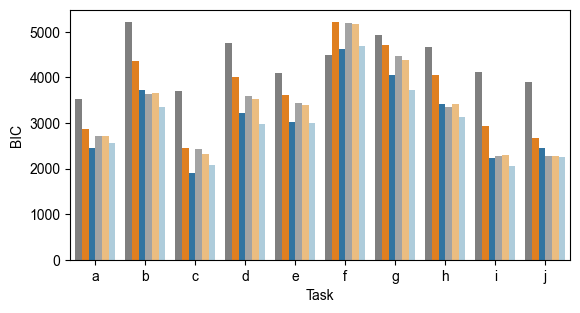

In [21]:
tag = 'no_canon'

plot_model_comparison(fit_models, tag=tag)
plt.show()

print_comparisons(fit_models)

parameter_table(fit_models)

model_bics = per_task_bic_for_all_models(dc, fit_models)
plot_model_comparison_between_task(dc, model_bics, tag=tag)

# Confound 2: No programming experience

In [22]:
if 'dc' in locals():
    del dc
    import gc
    gc.collect()

Dstrict = Dall.qualified(strict=True)
dc = lb.fitting.Analyses.confound_no_prog_exp(Dstrict)

Modal row count 34. # matching 193 / 235
# with no programming 125 / 235
# valid workers 125 / 235
Loading from cached file took 41.90 seconds. Last modified 2024-07-01T01:06:42.334946+00:00 (36 days, 14:50:16.430473 ago)


In [23]:
fit_models = lb.fitting.analysis(dc)

Loading from cached file took 0.08 seconds. Last modified 2024-07-01T12:19:55.156245+00:00 (36 days, 3:37:45.897160 ago)
score_reuse_and_reward FitResult(range=[9076.87, 9353.33], success=51/51, reach_minima=50/51, best_params=Args(b=2.159022628392653, prior_beta=0.3453548909856636, p_normal=0.9368357894282424, step_count_coef=0.6375652127101119), match_best_params=49/51, elapsed_sec_range=[965.73, 4240.97])
score_reuse FitResult(range=[9760.08, 10250.68], success=51/51, reach_minima=49/51, best_params=Args(b=4.154407282469455, prior_beta=0.4801365281637851, p_normal=0.8995607737814846), match_best_params=47/51, elapsed_sec_range=[407.35, 2404.40])
score_mdl_and_reward FitResult(range=[10943.20, 10943.20], success=51/51, reach_minima=51/51, best_params=Args(mdl_beta=0.3610350626313853, step_count_coef=1.0685696751421923), match_best_params=51/51, elapsed_sec_range=[14.17, 34.56])
score_mdl FitResult(range=[12522.19, 12522.19], success=51/51, reach_minima=51/51, best_params=Args(mdl_bet

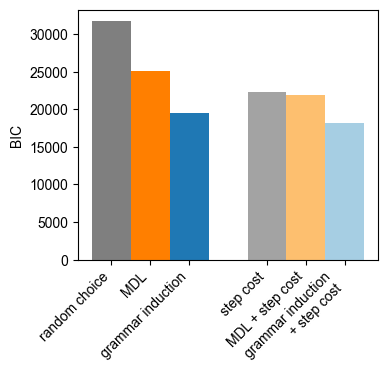

step cost, random choice, $\chi^2(1)=9416.8$, $p < .001$
MDL, random choice, $\chi^2(1)=6636.6$, $p < .001$
grammar induction, random choice, $\chi^2(3)=12160.8$, $p < .001$

MDL + step cost, step cost, $\chi^2(1)=377.8$, $p < .001$
grammar induction + step cost, step cost, $\chi^2(3)=4110.4$, $p < .001$

MDL + step cost, MDL, $\chi^2(1)=3158.0$, $p < .001$
grammar induction + step cost, grammar induction, $\chi^2(1)=1366.4$, $p < .001$
\begin{tabular}{lllrl}
\toprule
{} & \makecell{Log \\ likelihood} &      BIC &  \makecell{Param. \\ count} &                                                                                                                  Parameters \\
\midrule
\makecell{random choice}                             &                     -15840.5 &  31680.9 &                           0 &                                                                                                              \makecell[l]{} \\
\midrule \makecell{MDL}                              &      

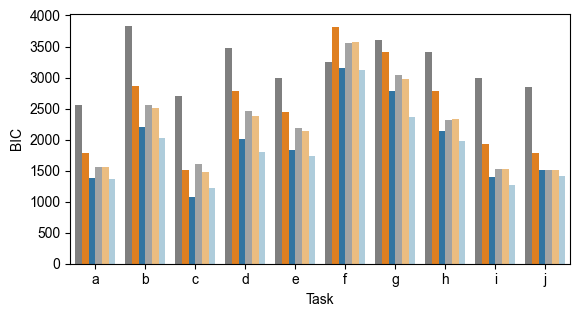

In [24]:
tag = 'no_prog_exp'

plot_model_comparison(fit_models, tag=tag)
plt.show()

print_comparisons(fit_models)

parameter_table(fit_models)

model_bics = per_task_bic_for_all_models(dc, fit_models)
plot_model_comparison_between_task(dc, model_bics, tag=tag)